# 1. Feature Engineering
In the first step of the solution I am trying to identify features that may derive from the data columns to improve the performace of a regression model.

<b>Data Columns:</b>
- Timestamp: Date and time of measurement
- Temperature: Degrees Celsius (°C)
- Dew Point: Degrees Celsius (°C)
- Surface Albedo: Decimal fraction between 0 and 1
- Pressure: Hectopascals (hPa)
- Wind Direction: Degrees (°)
- Wind Speed: Meters per second (m/s)
- Fill Flag: Binary (0 or 1) indicating if data was missing or not
- Ozone: Dobson Units (DU)
- Cloud Type: Classification scheme (0-9) indicating cloud cover type
- Solar Zenith Angle: Degrees (°)
- Precipitable Water: Millimeters (mm)
- Relative Humidity: Percentage (%)

<b>Prediction Goals:</b>
- Clearsky DHI: Watts per square meter (W/m²)
- Clearsky DNI: Watts per square meter (W/m²)
- Clearsky GHI: Watts per square meter (W/m²)

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./train.csv')
df.head()

,Timestamp,Temperature,Dew Point,Surface Albedo,Pressure,Wind Direction,Wind Speed,Clearsky DHI,Clearsky DNI,Clearsky GHI,Fill Flag,Ozone,Cloud Type,Solar Zenith Angle,Precipitable Water,Relative Humidity
0,2019-01-01 00:00:00,12.5,6.9,0.21,1005,121,1.0,0,0,0,0,0.258,1,173.92,1.4,68.82
1,2019-01-01 00:10:00,12.3,6.9,0.21,1005,122,1.0,0,0,0,0,0.258,1,171.79,1.3,69.73
2,2019-01-01 00:20:00,12.1,6.9,0.21,1005,124,1.0,0,0,0,0,0.258,1,169.59,1.3,70.65
3,2019-01-01 00:30:00,12.0,6.9,0.21,1005,125,1.0,0,0,0,0,0.258,1,167.37,1.3,71.11
4,2019-01-01 00:40:00,11.8,6.9,0.21,1005,126,1.0,0,0,0,0,0.258,1,165.13,1.3,71.91


Convert string values to datetime objects to improve accessability of all components.

In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')

## 1.1. Temperature & Dew Point

Text(0, 0.5, 'Dew Point [°C]')

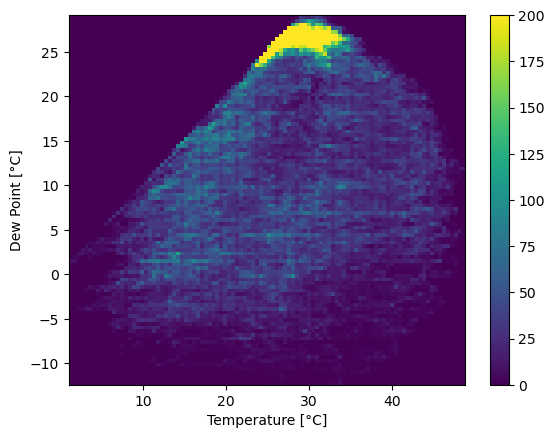

In [4]:
plt.hist2d(df['Temperature'], df['Dew Point'], bins=(100, 100), vmax=200)
plt.colorbar()
plt.xlabel('Temperature [°C]')
plt.ylabel('Dew Point [°C]')

In [5]:
df['Delta Dew Point'] = df['Temperature'].to_numpy() - df.pop('Dew Point')

Text(0, 0.5, 'Δ Dew Point [°C]')

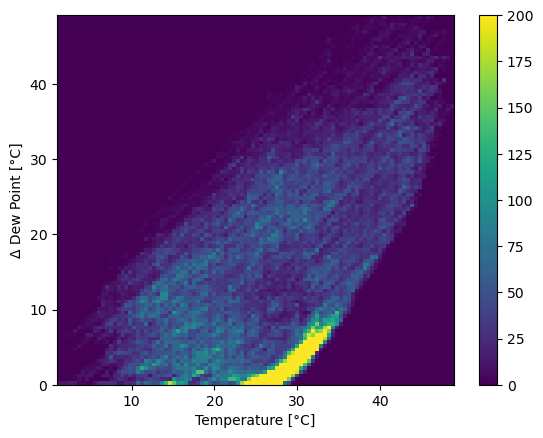

In [6]:
plt.hist2d(df['Temperature'], df['Delta Dew Point'], bins=(100, 100), vmax=200)
plt.colorbar()
plt.xlabel('Temperature [°C]')
plt.ylabel('Δ Dew Point [°C]')

## 1.2. Wind Direction & Speed

Text(0, 0.5, 'Wind Direction [°]')

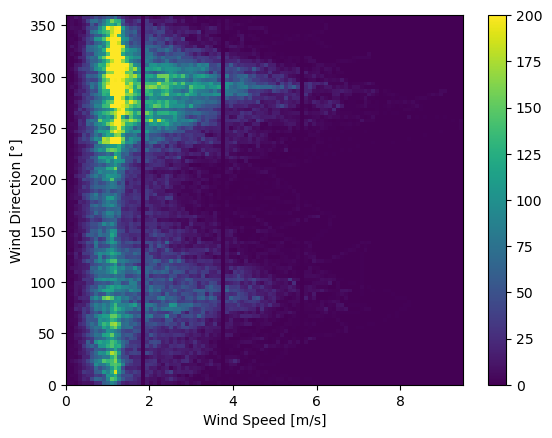

In [7]:
plt.hist2d(df['Wind Speed'], df['Wind Direction'], bins=(100, 100), vmax=200)
plt.colorbar()
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Wind Direction [°]')

In [8]:
ws = df.pop('Wind Speed')
wd = df.pop('Wind Direction')*np.pi / 180

df['Wind Vector X'] = ws*np.cos(wd)
df['Wind Vector Y'] = ws*np.sin(wd)

Text(0, 0.5, 'Wind Y [m/s]')

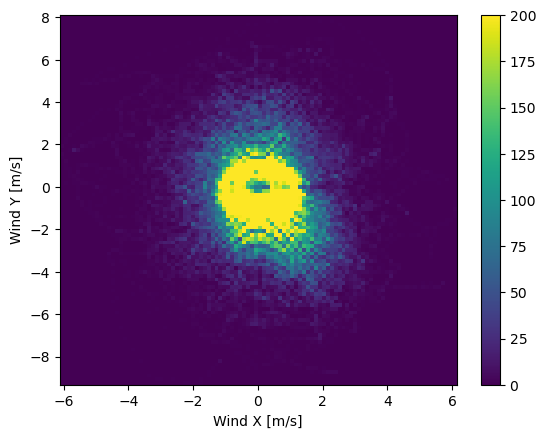

In [9]:
plt.hist2d(df['Wind Vector X'], df['Wind Vector Y'], bins=(100, 100), vmax=200)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')

## 1.3. Relative Humidity & Temperature

Text(0, 0.5, 'Relative Humidity [%]')

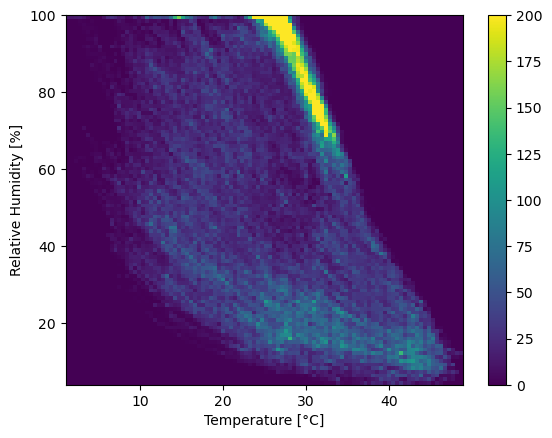

In [10]:
plt.hist2d(df['Temperature'], df['Relative Humidity'], bins=(100, 100), vmax=200)
plt.colorbar()
plt.xlabel('Temperature [°C]')
plt.ylabel('Relative Humidity [%]')

In [11]:
x_temp=np.array([0,-10,5,10,11,12,13,14,15,20,25,30,37])
y_sat_vap_dens=np.array([2.36,4.85,6.8,9.4,10.01,10.66,11.35,12.07,12.83,17.3,23,30.4,44])
z = np.polyfit(x_temp, y_sat_vap_dens, 2)
sat_vap_dens = np.poly1d(z)

In [12]:
df['Vapor Density'] = (df.pop('Relative Humidity')/100)*sat_vap_dens(df['Temperature'].to_numpy())

Text(0, 0.5, 'Vapor Density [g/m3]')

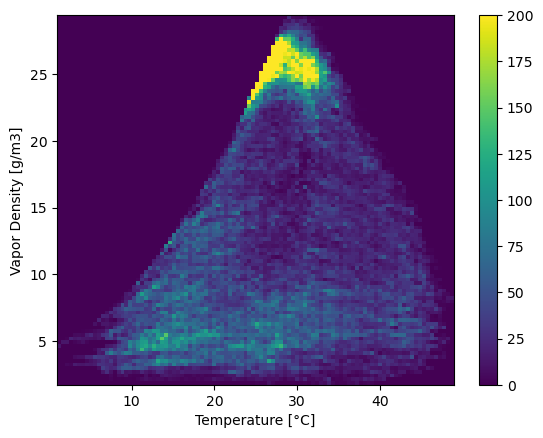

In [13]:
plt.hist2d(df['Temperature'], df['Vapor Density'], bins=(100, 100), vmax=200)
plt.colorbar()
plt.xlabel('Temperature [°C]')
plt.ylabel('Vapor Density [g/m3]')

## 1.4. Time

In [14]:
timestamp_s = df.pop('Timestamp').map(pd.Timestamp.timestamp)

In [15]:
hour = 60*60
day = 24*hour
year = (365.2425)*day

In [16]:
df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

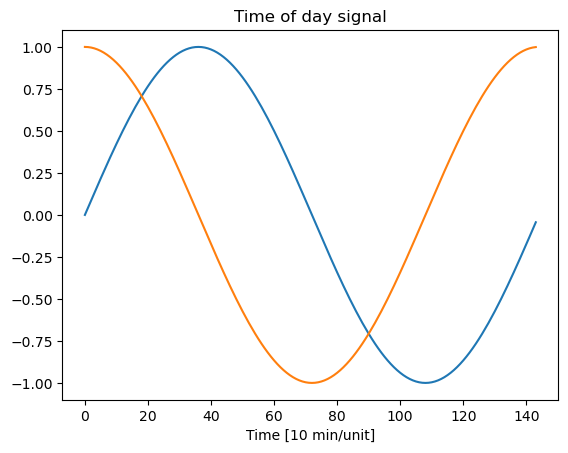

In [17]:
plt.plot(np.array(df['Day sin'])[:144])
plt.plot(np.array(df['Day cos'])[:144])
plt.xlabel('Time [10 min/unit]')
plt.title('Time of day signal')

## 1.5. One-Hot-Encoding Cloud Type 

In [18]:
max_c_type, min_c_type = max(df['Cloud Type']), min(df['Cloud Type'])
print('Max.:', max_c_type)
print('Min.:', min_c_type)

Max.: 9
Min.: 0


In [19]:
df['Cloud Type'] = [[0]*x+[1]+[0]*(max_c_type-x) for x in df.pop('Cloud Type')]

## 1.6. Dropping Fill Flag

In [20]:
ff = df.pop('Fill Flag')

# 2. Data Preparation
In the second step of the solution I am trying to garther the features and prepare them so I can use them as a dataset.

<b>Features:</b>
- Hour sin
- Hour cos
- Day sin
- Day cos
- Year sin
- Year cos
- Temperature: Degrees Celsius (°C)
- Δ Dew Point: Degrees Celsius (°C)
- Surface Albedo: Decimal fraction between 0 and 1
- Pressure: Hectopascals (hPa)
- Wind Vector X: Meters per second (m/s)
- Wind Vector Y: Meters per second (m/s)
- Ozone: Dobson Units (DU)
- Cloud Type: One-Hot-Encoding (0-9)
- Solar Zenith Angle: Degrees (°)
- Precipitable Water: Millimeters (mm)
- Vapor Density: g/m3

<b>Prediction Goals:</b>
- Clearsky DHI: Watts per square meter (W/m²)
- Clearsky DNI: Watts per square meter (W/m²)
- Clearsky GHI: Watts per square meter (W/m²)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocess as mp

from itertools import chain
from tqdm.auto import tqdm

In [22]:
CONT_FEATURES = [
    'Temperature',
    'Surface Albedo',
    'Pressure',
    'Ozone',
    'Solar Zenith Angle',
    'Precipitable Water',
    'Delta Dew Point',
    'Wind Vector X',
    'Wind Vector Y',
    'Vapor Density',
    'Hour sin',
    'Hour cos',
    'Day sin',
    'Day cos',
    'Year sin',
    'Year cos',
]
CAT_FEATURES = [
    'Cloud Type',
]

In [23]:
LABELS = [
    'Clearsky DHI',
    'Clearsky DNI',
    'Clearsky GHI',
]

In [24]:
df.head()

,Temperature,Surface Albedo,Pressure,Clearsky DHI,Clearsky DNI,Clearsky GHI,Ozone,Solar Zenith Angle,Precipitable Water,Delta Dew Point,Wind Vector X,Wind Vector Y,Vapor Density,Hour sin,Hour cos,Day sin,Day cos,Year sin,Year cos,Cloud Type
0,12.5,0.21,1005,0,0,0,0.258,173.92,1.4,5.6,-0.515038,0.857167,7.311469,1.121084e-10,1.0,-5.030095e-12,1.000000,0.002021,0.999998,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,12.3,0.21,1005,0,0,0,0.258,171.79,1.3,5.4,-0.529919,0.848048,7.299968,8.660254e-01,0.5,4.361939e-02,0.999048,0.002141,0.999998,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,12.1,0.21,1005,0,0,0,0.258,169.59,1.3,5.2,-0.559193,0.829038,7.287946,8.660254e-01,-0.5,8.715574e-02,0.996195,0.002260,0.999997,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,12.0,0.21,1005,0,0,0,0.258,167.37,1.3,5.1,-0.573576,0.819152,7.281356,9.433638e-12,-1.0,1.305262e-01,0.991445,0.002380,0.999997,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,11.8,0.21,1005,0,0,0,0.258,165.13,1.3,4.9,-0.587785,0.809017,7.254943,-8.660254e-01,-0.5,1.736482e-01,0.984808,0.002499,0.999997,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


## 2.1. Preview Normalization

In [25]:
cont_filter = lambda x: x[CONT_FEATURES]

In [26]:
df_cont = cont_filter(df)
df_mean = df_cont.mean()
df_std = df_cont.std()

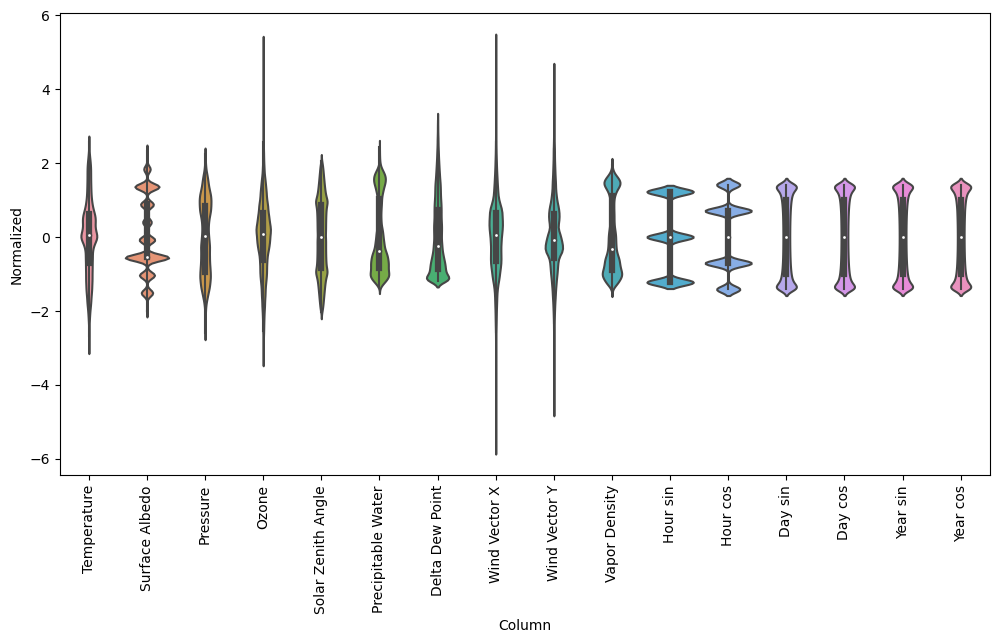

In [27]:
df_std = (df_cont - df_mean) / df_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_cont.keys(), rotation=90)

## 2.2. Combine Features

In [28]:
feature_filter = lambda r: list(r[CONT_FEATURES].values)+list(chain.from_iterable(r[CAT_FEATURES].values))

In [ ]:
vectorized_features = []
max_index = len(df)
for _, row in tqdm(df.iterrows(), total=max_index):
    vectorized_features.append(feature_filter(row))

In [30]:
df = df.drop(CONT_FEATURES+CAT_FEATURES, axis=1)
df['Features'] = vectorized_features
df.head()

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Features
0,0,0,0,"[12.5, 0.21, 1005, 0.258, 173.92, 1.4, 5.6, -0..."
1,0,0,0,"[12.3, 0.21, 1005, 0.258, 171.79, 1.3, 5.4, -0..."
2,0,0,0,"[12.1, 0.21, 1005, 0.258, 169.59, 1.3, 5.19999..."
3,0,0,0,"[12.0, 0.21, 1005, 0.258, 167.37, 1.3, 5.1, -0..."
4,0,0,0,"[11.8, 0.21, 1005, 0.258, 165.13, 1.3, 4.9, -0..."


## 2.3. Combine Labels

In [31]:
label_filter = lambda r: list(r[LABELS].values)

In [ ]:
vectorized_labels = []
max_index = len(df)
for _, row in tqdm(df.iterrows(), total=max_index):
    label_vec = label_filter(row)
    vectorized_labels.append(label_vec)

In [33]:
df = df.drop(LABELS, axis=1)
df['Labels'] = vectorized_labels
df.head()

,Features,Labels
0,"[12.5, 0.21, 1005, 0.258, 173.92, 1.4, 5.6, -0...","[0, 0, 0]"
1,"[12.3, 0.21, 1005, 0.258, 171.79, 1.3, 5.4, -0...","[0, 0, 0]"
2,"[12.1, 0.21, 1005, 0.258, 169.59, 1.3, 5.19999...","[0, 0, 0]"
3,"[12.0, 0.21, 1005, 0.258, 167.37, 1.3, 5.1, -0...","[0, 0, 0]"
4,"[11.8, 0.21, 1005, 0.258, 165.13, 1.3, 4.9, -0...","[0, 0, 0]"


## 2.4. Windowing

In [34]:
def windowing(curr_df, offset, window_params, default_vec):
    window_size, day_window, days = window_params
    default_label = [0]*3
    vectorized_collection = []
    for i in range(offset, len(curr_df)):
        curr_days = math.floor(i / day_window)
        curr_days = curr_days if curr_days <= days else days
        for j in range(0, curr_days+1):
            curr_vec = [default_vec]*window_size*(days-j)
            for k in range(0, j+1):
                curr_window = i-k*day_window
                max_window = window_size if curr_window+1 > window_size else curr_window+1
                curr_vec.extend([default_vec]*(window_size-max_window))
                curr_vec.extend(
                    [((curr_df.iloc[m]['Features']+curr_df.iloc[m]['Labels']) if m != curr_window else
                     (curr_df.iloc[m]['Features']+default_label))
                     for m in range((i+1-max_window)-(k*day_window), curr_window+1)]
                )
            vectorized_collection.append((curr_vec, curr_df.iloc[i]['Labels']))
    return vectorized_collection

In [ ]:
BATCH = 128
window_size = 18 #3*6 -> 10min/step
day_window = 144 #24*6 -> 10min/step
days = 2
default_vec = [0]*29
max_offset = window_size+days*day_window
calc_offset = lambda i: max_offset if i > max_offset else i

pool = mp.Pool(mp.cpu_count())
vectorized_collection = [pool.apply(windowing, args=(df.iloc[(i-calc_offset(i)):i+BATCH], calc_offset(i), (window_size, day_window, days), default_vec)) for i in tqdm(range(0, len(df), BATCH))]
pool.close()

In [36]:
vectorized_collection_combined = []
for e in vectorized_collection:
    vectorized_collection_combined.extend(e)

In [37]:
df_preview = pd.DataFrame(vectorized_collection_combined, columns=['Features', 'Labels'])
df_preview.head()

,Features,Labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0]"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0]"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0]"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0]"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0]"


# 3.Training

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime

%load_ext tensorboard
from tensorflow.python.keras import layers
from tqdm.auto import tqdm

In [39]:
unzipped = list(zip(*vectorized_collection_combined))
train_features = list(unzipped[0])
train_labels = list(unzipped[1])

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
train_features = np.array(train_features)
train_labels = np.vstack(train_labels).astype(float)
normalizer.adapt(train_features)

In [41]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      layers.LSTM(64, activation='sigmoid'),
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.1),
      layers.Dense(3, activation='relu')
  ])

  model.compile(loss='mse',
                metrics=['mae'],
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model

In [42]:
model = build_and_compile_model(normalizer)

In [43]:
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [44]:
#%tensorboard --logdir logs/fit

In [45]:
history = model.fit(
    train_features,
    train_labels,
    batch_size=512,
    validation_split=0.2, 
    epochs=25,
    callbacks=[tensorboard_callback]
)

Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/25
985/985 [==============================] - 146s 147ms/step - loss: 92816.1172 - mae: 175.6872 - val_loss: 84036.7109 - val_mae: 164.9897
Epoch 2/25
985/985 [==============================] - 141s 144ms/step - loss: 61509.2500 - mae: 133.9284 - val_loss: 50132.4766 - val_mae: 116.4421
Epoch 3/25
985/985 [==============================] - 141s 143ms/step - loss: 33294.1836 - mae: 90.9074 - val_loss: 25349.5781 - va

# 4. Evaluation

In [70]:
df_test = pd.read_csv('./test.csv')
df_test.head()

In [47]:
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'], format='%Y-%m-%d %H:%M:%S')

In [48]:
df_test['Delta Dew Point'] = df_test['Temperature'].to_numpy() - df_test.pop('Dew Point')

In [49]:
ws = df_test.pop('Wind Speed')
wd = df_test.pop('Wind Direction')*np.pi / 180

df_test['Wind Vector X'] = ws*np.cos(wd)
df_test['Wind Vector Y'] = ws*np.sin(wd)

In [50]:
x_temp=np.array([0,-10,5,10,11,12,13,14,15,20,25,30,37])
y_sat_vap_dens=np.array([2.36,4.85,6.8,9.4,10.01,10.66,11.35,12.07,12.83,17.3,23,30.4,44])
z = np.polyfit(x_temp, y_sat_vap_dens, 2)
sat_vap_dens = np.poly1d(z)

In [51]:
df_test['Vapor Density'] = (df_test.pop('Relative Humidity')/100)*sat_vap_dens(df_test['Temperature'].to_numpy())

In [52]:
timestamp_s = df_test.pop('Timestamp').map(pd.Timestamp.timestamp)

In [53]:
hour = 60*60
day = 24*hour
year = (365.2425)*day

In [54]:
df_test['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df_test['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df_test['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_test['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_test['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_test['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [55]:
max_c_type, min_c_type = max(df_test['Cloud Type']), min(df_test['Cloud Type'])
print('Max.:', max_c_type)
print('Min.:', min_c_type)

Max.: 9
Min.: 0


In [56]:
df_test['Cloud Type'] = [[0]*x+[1]+[0]*(max_c_type-x) for x in df_test.pop('Cloud Type')]

In [57]:
ff = df_test.pop('Fill Flag')

In [58]:
CONT_FEATURES = [
    'Temperature',
    'Surface Albedo',
    'Pressure',
    'Ozone',
    'Solar Zenith Angle',
    'Precipitable Water',
    'Delta Dew Point',
    'Wind Vector X',
    'Wind Vector Y',
    'Vapor Density',
    'Hour sin',
    'Hour cos',
    'Day sin',
    'Day cos',
    'Year sin',
    'Year cos',
]
CAT_FEATURES = [
    'Cloud Type',
]

In [59]:
LABELS = [
    'Clearsky DHI',
    'Clearsky DNI',
    'Clearsky GHI',
]

In [60]:
df_test.head()

,Temperature,Surface Albedo,Pressure,Clearsky DHI,Clearsky DNI,Clearsky GHI,Ozone,Solar Zenith Angle,Precipitable Water,Delta Dew Point,Wind Vector X,Wind Vector Y,Vapor Density,Hour sin,Hour cos,Day sin,Day cos,Year sin,Year cos,Cloud Type
0,11.3,0.21,1006,NaN,NaN,NaN,0.255,173.92,1.4,9.7,0.688292,-0.982982,4.994226,7.822485e-11,1.0,-1.129255e-11,1.000000,0.002537,0.999997,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,11.2,0.21,1006,NaN,NaN,NaN,0.255,171.79,1.4,9.6,0.705342,-0.970820,4.989829,8.660254e-01,0.5,4.361939e-02,0.999048,0.002657,0.999996,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,11.1,0.21,1006,NaN,NaN,NaN,0.255,169.59,1.4,9.5,0.705342,-0.970820,4.985174,8.660254e-01,-0.5,8.715574e-02,0.996195,0.002776,0.999996,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,11.0,0.21,1006,NaN,NaN,NaN,0.255,167.37,1.4,9.4,0.722178,-0.958363,4.981216,4.331716e-11,-1.0,1.305262e-01,0.991445,0.002896,0.999996,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,10.9,0.21,1006,NaN,NaN,NaN,0.255,165.13,1.4,9.7,0.722178,-0.958363,4.843042,-8.660254e-01,-0.5,1.736482e-01,0.984808,0.003015,0.999995,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [61]:
feature_filter = lambda r: list(r[CONT_FEATURES].values)+list(chain.from_iterable(r[CAT_FEATURES].values))

In [ ]:
vectorized_features = []
max_index = len(df_test)
for _, row in tqdm(df_test.iterrows(), total=max_index):
    vectorized_features.append(feature_filter(row))

In [63]:
df_test = df_test.drop(CONT_FEATURES+CAT_FEATURES, axis=1)
df_test['Features'] = vectorized_features
df_test.head()

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Features
0,NaN,NaN,NaN,"[11.3, 0.21, 1006, 0.255, 173.92, 1.4, 9.70000..."
1,NaN,NaN,NaN,"[11.2, 0.21, 1006, 0.255, 171.79, 1.4, 9.6, 0...."
2,NaN,NaN,NaN,"[11.1, 0.21, 1006, 0.255, 169.59, 1.4, 9.5, 0...."
3,NaN,NaN,NaN,"[11.0, 0.21, 1006, 0.255, 167.37, 1.4, 9.4, 0...."
4,NaN,NaN,NaN,"[10.9, 0.21, 1006, 0.255, 165.13, 1.4, 9.70000..."


In [64]:
df_test = df_test.drop(LABELS, axis=1)
df_test.head()

,Features
0,"[11.3, 0.21, 1006, 0.255, 173.92, 1.4, 9.70000..."
1,"[11.2, 0.21, 1006, 0.255, 171.79, 1.4, 9.6, 0...."
2,"[11.1, 0.21, 1006, 0.255, 169.59, 1.4, 9.5, 0...."
3,"[11.0, 0.21, 1006, 0.255, 167.37, 1.4, 9.4, 0...."
4,"[10.9, 0.21, 1006, 0.255, 165.13, 1.4, 9.70000..."


In [68]:
def predict(curr_df, window_params, default_vec, model):
    window_size, day_window, days = window_params
    default_label = [0]*3
    output = []
    labels = [0,0,0]*len(curr_df)
    for i in tqdm(range(0, len(curr_df))):
        curr_days = math.floor(i / day_window)
        curr_days = curr_days if curr_days <= days else days
        curr_vec = [default_vec]*window_size*(days-curr_days)
        for k in range(0, curr_days+1):
            curr_window = i-k*day_window
            max_window = window_size if curr_window+1 > window_size else curr_window+1
            curr_vec.extend([default_vec]*(window_size-max_window))
            curr_vec.extend(
                [((curr_df.iloc[m]['Features']+labels[m]) if m != curr_window else
                 (curr_df.iloc[m]['Features']+default_label))
                 for m in range((i+1-max_window)-(k*day_window), curr_window+1)]
            )
        prediction = model.predict([curr_vec])[0]
        labels[i] = prediction.tolist()
        output.append(prediction)
    return output

In [69]:
window_size = 18 #3*6 -> 10min/step
day_window = 144 #24*6 -> 10min/step
days = 2
default_vec = [0]*29

output = predict(df_test, (window_size, day_window, days), default_vec, model)
output = [tuple([round(v, 2) if v >= 0 else 0 for v in x]) for x in output]

In [ ]:
print(len(output))
print(output[0])

In [ ]:
df_result = pd.DataFrame(output, columns=['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'])
df_result.head()

In [ ]:
df_result.to_csv('result.csv', index=False, float_format='%.2f')